In [1]:
%load_ext edx_jupyter

In [2]:
x = %vertica SELECT 'Connected to Vertica!'
print(x.loc[0][0])

password: ········
Connected to Vertica!


In [3]:
import datetime
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
intervention_date = datetime.date(2017,6,5)
window_end_date = intervention_date + datetime.timedelta(days=28)
print(window_end_date)

2017-07-03


We are analyzing data from the date the email was sent (2017-06-05) to three weeks after that date (2017-07-03).

The `ret.email_experiment` table contains the breakdown of users into control and treatment groups, we first pull the totals for each group out of this table since it will be used quite a bit below.

In [6]:
%%vertica -> group_sizes
SELECT
    group_name,
    COUNT(*)
FROM
    ret.email_experiment
GROUP BY 1

In [7]:
group_sizes.set_index('group_name', inplace=True)

In [8]:
group_sizes

,COUNT
group_name,
Sent Email,74963
Control,74829


## Extract recent activity from the event log

Unfortunately our [f_user_activity](https://openedx.atlassian.net/wiki/display/DE/Table%3A+production.f_user_activity) table is only updated weekly, so we fill in the gaps with data from the raw tracking logs. Care is taken here to match the definitions of activity from [the data pipeline](https://github.com/edx/edx-analytics-pipeline/blob/master/edx/analytics/tasks/insights/user_activity.py#L61).

**Note**: This operation is destructive and overwrites the table!

In [31]:
%%vertica
DROP TABLE IF EXISTS public.recent_user_engagement;
CREATE TABLE public.recent_user_engagement AS
SELECT
    user_id,
    course_id,
    date,
    CASE WHEN number_of_activities > 0 THEN 1 ELSE 0 END AS is_engaged
FROM
(
    SELECT
        context_user_id::INT AS user_id,
        context_course_id AS course_id,
        DATE(timestamp) AS date,
        CASE
            WHEN event_type = 'problem_check' THEN 'ATTEMPTED_PROBLEM'
            WHEN event_type = 'play_video' THEN 'PLAYED_VIDEO'
            ELSE 'POSTED_FORUM'
        END AS activity_type,
        COUNT(*) AS number_of_activities
    FROM
        experimental_events_run14.event_records
    WHERE
        project='tracking_prod'
        AND (
            (event_source='server' AND event_type='problem_check')
            OR (event_type LIKE 'edx.forum.%.created')
            OR (event_source IN ('browser', 'mobile') AND event_type='play_video')
        )
        AND DATE(timestamp) > (SELECT MAX(date) FROM business_intelligence.activity_engagement_user_daily)
        AND DATE(timestamp) < NOW()
    GROUP BY
        1, 2, 3, 4
) a;
GRANT SELECT ON public.recent_user_engagement TO standard;

,EXPORT_OBJECTS


# Engagement

## Extract the time of first engagement after the email was sent for each user

In [32]:
%%vertica (intervention_date=intervention_date, window_end_date=window_end_date) -> return_rate
SELECT
    returned_after,
    group_name,
    COUNT(user_id)
FROM
(
    SELECT
        ee.user_id,
        ee.group_name,
        DATEDIFF('day', :intervention_date, MIN(act.date)) as returned_after
    FROM
        ret.email_experiment ee
    LEFT JOIN
            public.all_user_engagement as act
         ON act.user_id = ee.user_id
        AND act.course_id = ee.course_id
        AND act.date BETWEEN :intervention_date AND :window_end_date
        AND act.is_engaged = 1
    WHERE
        ee.experiment_id = 0
    GROUP BY
        1, 2
) as return
GROUP BY
    1, 2
ORDER BY 1

This is the number of users whose first re-engagement with the platform is `returned_after` days after the email was sent for each group.

In [33]:
return_rates_ix = return_rate.dropna().set_index(['group_name', 'returned_after'])
return_rates_ix

,,COUNT
group_name,returned_after,
Control,0.0,989
Sent Email,0.0,1377
Control,1.0,986
Sent Email,1.0,1410
Control,2.0,724
Sent Email,2.0,870
Control,3.0,507
Sent Email,3.0,657
Control,4.0,509


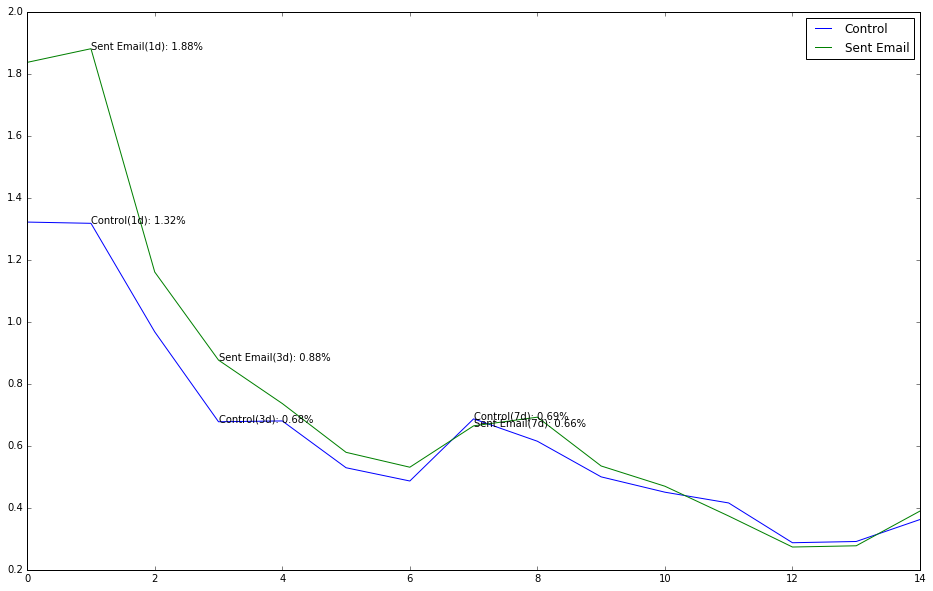

In [76]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = return_rates_ix.loc[group_name]
    x = list(data.index)
    y = list((data.COUNT/group_sizes.loc[group_name].COUNT)*100)
    plt.plot(x, y, label=group_name)
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x])
        )
    plt.legend()

## Number of users returning on each day relative to email send date

In [35]:
%%vertica (intervention_date=intervention_date, window_end_date=window_end_date) -> return_users
SELECT
    returned_after,
    group_name,
    COUNT(user_id)
FROM
(
    SELECT
        ee.user_id,
        ee.group_name,
        DATEDIFF('day', :intervention_date, act.date) as returned_after
    FROM
        ret.email_experiment ee
    LEFT JOIN
            public.all_user_engagement as act
         ON act.user_id = ee.user_id
        AND act.course_id = ee.course_id
        AND act.date BETWEEN :intervention_date AND :window_end_date
        AND act.is_engaged = 1
    WHERE
        ee.experiment_id = 0
) as return
GROUP BY
    1, 2
ORDER BY 1

In [36]:
return_users_ix = return_users.dropna().set_index(['group_name', 'returned_after'])
return_users_ix

,,COUNT
group_name,returned_after,
Control,0.0,989
Sent Email,0.0,1377
Control,1.0,1267
Sent Email,1.0,1792
Control,2.0,1184
Sent Email,2.0,1479
Control,3.0,979
Sent Email,3.0,1284
Control,4.0,958


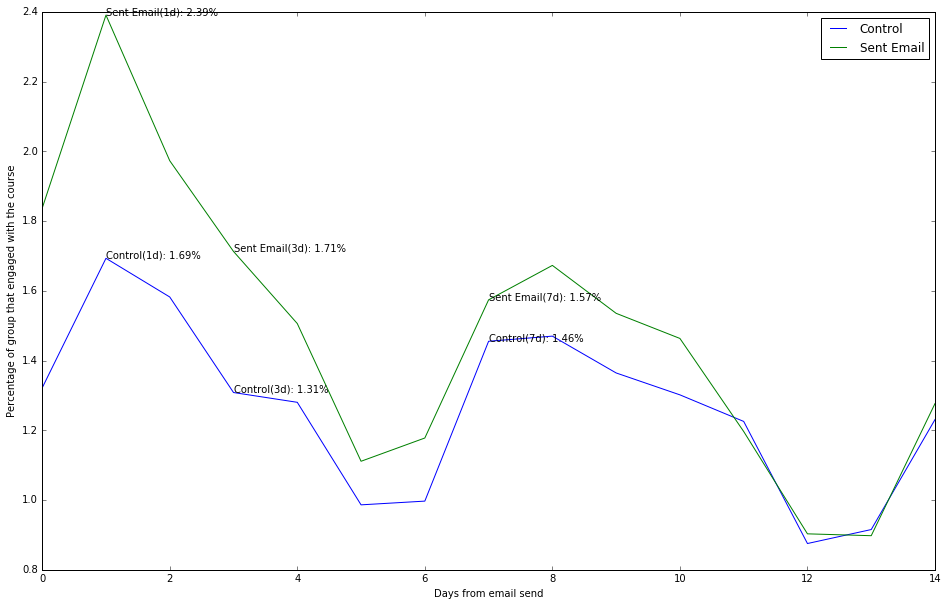

In [37]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = return_users_ix.loc[group_name]
    x = list(data.index)
    y = list((data.COUNT/group_sizes.loc[group_name].COUNT)*100)
    plt.plot(x, y, label=group_name)
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x])
        )
    plt.legend()
ax = fig.get_axes()[0]
ax.set_xlabel('Days from email send')
ax.set_ylabel('Percentage of group that engaged with the course')
None

## Cumulative users who have returned as of each day from send date

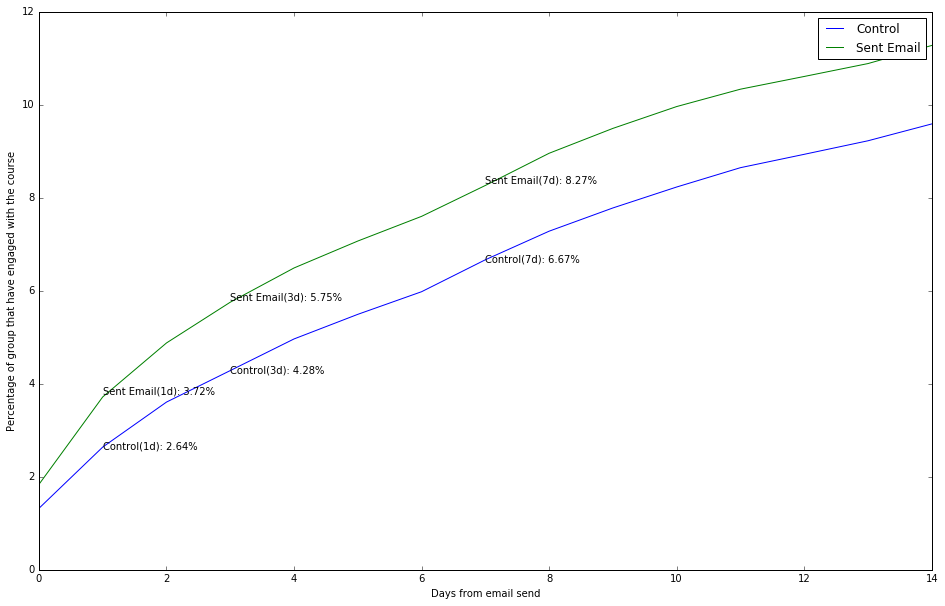

In [38]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = return_rates_ix.loc[group_name]
    x = list(data.index)
    y = list((data.COUNT.cumsum()/group_sizes.loc[group_name].COUNT)*100)
    plt.plot(x, y, label=group_name)
    if group_name == 'Control':
        y_offset = -0.05
    else:
        y_offset = 0.05
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x] + y_offset)
        )
    plt.legend()
ax = fig.get_axes()[0]
ax.set_xlabel('Days from email send')
ax.set_ylabel('Percentage of group that have engaged with the course')
None

To evaluate statistical significance using a chi-square test. The [contingency table](https://en.wikipedia.org/wiki/Contingency_table) looks like this:

| | Did not re-engage within n days | Re-engaged within n days |
| - | ---- | ---- |
| Sent Email (Treatment) | x | y |
| Control | z | w |

We can then evaluate the probability that these frequencies would be observed if there was no significant difference between the treatment and control groups.

In [39]:
import numpy as np
from scipy.stats import chi2_contingency

def check_statistical_significance(data, n_days=1, significance_level=0.1):
    treatment_returned_users = data.loc['Sent Email'].COUNT.cumsum()[n_days]
    control_returned_users = data.loc['Control'].COUNT.cumsum()[n_days]

    contingency_table = np.array([
        [group_sizes.loc['Sent Email'].COUNT - treatment_returned_users, treatment_returned_users],
        [group_sizes.loc['Control'].COUNT - control_returned_users, control_returned_users],
    ])
    g, p, dof, expected = chi2_contingency(contingency_table)
    treatment_p_return = treatment_returned_users / float(group_sizes.loc['Sent Email'].COUNT)
    control_p_return = control_returned_users / float(group_sizes.loc['Control'].COUNT)
    effect_size = (treatment_p_return - control_p_return) / control_p_return
    return (p, effect_size, p < significance_level)

In [74]:
check_statistical_significance(return_rates_ix, 1)

(1.4850717034138221e-32, 0.40861676063989028, True)

We see a **40%** increase in the probability to return and engage with the course within 1 day of the email send. This result is statisitically significant.

In [77]:
check_statistical_significance(return_rates_ix, 3)

(9.5464801726914345e-39, 0.34319666739480026, True)

We see a **34%** increase in the probability to return and engage with the course within 3 days of the email send. This result is statisitically significant.

In [78]:
check_statistical_significance(return_rates_ix, 7)

(6.5705709168205778e-32, 0.23971223679007342, True)

We see a **24%** increase in the probability to return and engage with the course within 7 days of the email send. This result is statisitically significant.

# Verification

## Extract the time of first upgrade to verified after the email was sent for each user

In [43]:
%%vertica (intervention_date=intervention_date, window_end_date=window_end_date) -> verify_rates
SELECT
    verified_after,
    group_name,
    COUNT(user_id)
FROM
(
    SELECT
        ee.user_id,
        ee.group_name,
        DATEDIFF('day', :intervention_date, MIN(crs.first_verified_enrollment_time)) as verified_after
    FROM
        ret.email_experiment ee
    LEFT JOIN
            production.d_user_course as crs
        ON ee.user_id = crs.user_id
        AND ee.course_id = crs.course_id
        AND crs.first_verified_enrollment_time BETWEEN :intervention_date AND :window_end_date
    WHERE
        ee.experiment_id = 0
    GROUP BY
        1, 2
) as return
GROUP BY
    1, 2
ORDER BY 1

In [44]:
verify_rates_ix = verify_rates.dropna().set_index(['group_name', 'verified_after'])
verify_rates_ix

,,COUNT
group_name,verified_after,
Control,0.0,11
Sent Email,0.0,15
Control,1.0,15
Sent Email,1.0,18
Control,2.0,19
Sent Email,2.0,22
Control,3.0,27
Sent Email,3.0,10
Control,4.0,14


## Number of users upgrading on each day relative to email send date

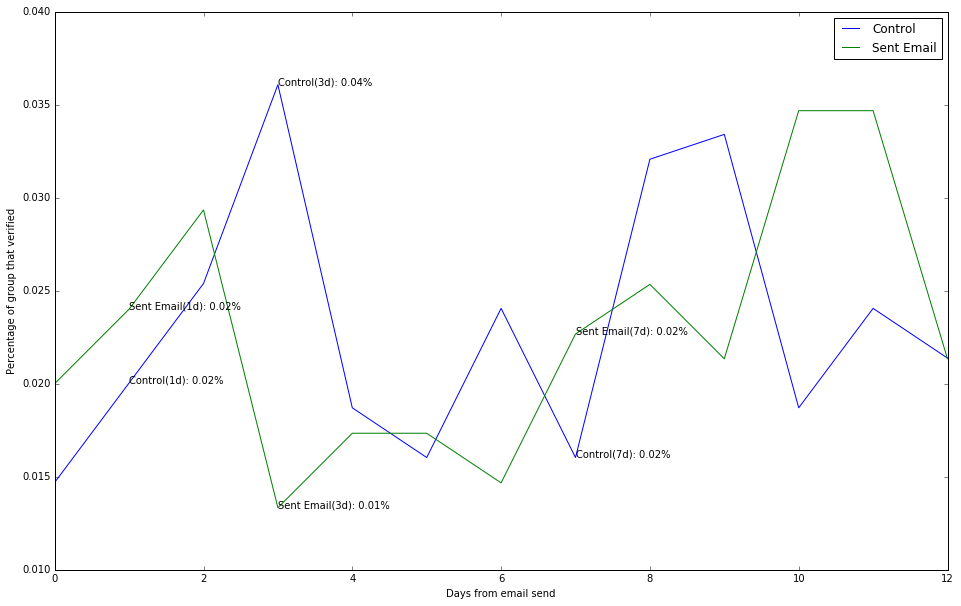

In [45]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = verify_rates_ix.loc[group_name]
    x = list(data.index)
    y = list((data.COUNT/group_sizes.loc[group_name].COUNT)*100)
    plt.plot(x, y, label=group_name)
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x])
        )
    plt.legend()
ax = fig.get_axes()[0]
ax.set_xlabel('Days from email send')
ax.set_ylabel('Percentage of group that verified')
None

## Cumulative users who have verified as of each day from send date

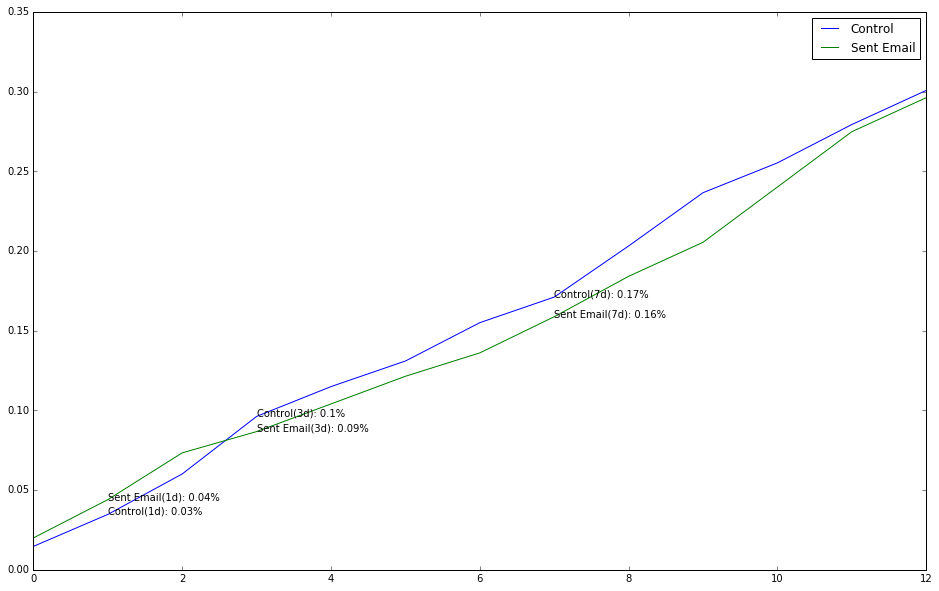

In [46]:
fig = plt.figure(figsize=(16, 10))
for group_name in group_sizes.index:
    data = verify_rates_ix.loc[group_name]
    x = list(data.index)
    y = list(data.COUNT.cumsum()/group_sizes.loc[group_name].COUNT*100)
    plt.plot(x, y, label=group_name)
    y_offset = 0
    for ann_x in (1, 3, 7, 21, 28):
        if x[-1] < ann_x:
            break
        plt.annotate(
            '{0}({1}d): {2}%'.format(group_name, ann_x, round(y[ann_x], 2)),
            xy=(ann_x, y[ann_x]),
            xytext=(ann_x, y[ann_x] + y_offset)
        )
    plt.legend()

## Compute the confidence interval

In [79]:
%%vertica (intervention_date=intervention_date, window_end_date=window_end_date) -> returns_raw
SELECT
    ee.user_id,
    ee.group_name,
    CASE WHEN DATEDIFF('day', :intervention_date, MIN(act.date)) <= 7 THEN 1 ELSE 0 END as returned
FROM
    ret.email_experiment ee
LEFT JOIN
        public.all_user_engagement as act
     ON act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND act.date BETWEEN :intervention_date AND :window_end_date
    AND act.is_engaged = 1
WHERE
    ee.experiment_id = 0
GROUP BY
    1, 2

In [80]:
returns = returns_raw.set_index('group_name')

In [81]:
returns.head()

,user_id,returned
group_name,,
Control,14208613,0
Control,2811693,0
Control,9059541,0
Control,12307173,0
Sent Email,1892342,0


In [82]:
import datetime
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import statsmodels.stats.api as sms
import pandas as pd

In [83]:
def plot_confidence_interval(res, axes):
    bar_height = 0.25
    axes.axvline(x=0)
    face_color = '0.75'
    if res.lower_bound > 0:
        face_color = 'lightgreen'
    elif res.upper_bound < 0:
        face_color = 'lightred'
    axes.add_patch(
        patches.Rectangle(
            (res.lower_bound, -(bar_height / 2)),
            res.upper_bound - res.lower_bound,
            bar_height,
            facecolor=face_color
        )
    )
    axes.add_line(Line2D([res.value, res.value], [-(bar_height / 2), (bar_height / 2)], color='k'))
    axes.text(res.lower_bound-0.5, (bar_height/2)*1.1, str(round(res.lower_bound, 2)) + '%')
    axes.text(res.value, -(bar_height/2)*2, str(round(res.value, 2)) + '%')
    axes.text(res.upper_bound, (bar_height/2)*1.1, str(round(res.upper_bound, 2)) + '%')

In [84]:
def plot_comparative_intervals(intervals, titles):
    num_intervals = len(intervals)
    f, axarr = plt.subplots(num_intervals, sharex=True)
    try:
        axarr[0]
    except TypeError:
        axarr = [axarr]
        
    max_x = 0
    for interval in intervals:
        if abs(interval.lower_bound) > max_x:
            max_x = abs(interval.lower_bound)
        if abs(interval.upper_bound) > max_x:
            max_x = abs(interval.upper_bound)
    
    for index, interval in enumerate(intervals):
        axarr[index].set_xlim([-(max_x*1.3), max_x*1.3])
        axarr[index].set_ylim([-1, 1])
        axarr[index].set_title(titles[index])
        plot_confidence_interval(interval, axarr[index])

In [85]:
def test_significance(control_data, test_data):
    bs_res = bs.bootstrap_ab(
        test_data,
        control_data,
        stat_func=bs_stats.mean,
        compare_func=bs_compare.percent_change,
        num_iterations=10000,
        num_threads=-1,
        alpha=alpha
    )
    return bs_res

In [86]:
def summarize_conversion_rate(label, data):
    relative_change = bs_compare.percent_change(data.mean(), ctrl.mean())
    print('{0} {1}/{2} CR={3}% Change={4}{5}%'.format(
        label,
        round(data.sum(), 2),
        len(data),
        round(data.mean() * 100, 2),
        '+' if relative_change >= 0 else '',
        round(relative_change, 2)
    ))

In [87]:
alpha = 0.1
effect_size = 0.2
power = 0.8

--- Summary of groups ---
Original 4989/74829 CR=6.67% Change=+0.0%
Sent Email 6196/74963 CR=8.27% Change=+23.97%

--- Necessary sample size per group ---
At least 4717 users per group

--- Sent Email ---
23.97122367900734    (20.15561452279683, 27.70731876568174)



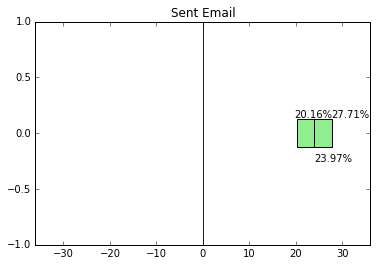

In [88]:
ctrl = np.array(returns.loc['Control'].returned)
test = np.array(returns.loc['Sent Email'].returned)

print('--- Summary of groups ---')
summarize_conversion_rate('Original', ctrl)
summarize_conversion_rate('Sent Email', test)
print()

print('--- Necessary sample size per group ---')
es = sms.proportion_effectsize(ctrl.mean(), ctrl.mean()*(1 + effect_size))
sample_size = round(sms.NormalIndPower().solve_power(es, power=power, alpha=alpha, ratio=1))
print('At least {0} users per group'.format(sample_size))
print()

print('--- Sent Email ---')
test_ci = test_significance(ctrl, test)
print(test_ci)
print()

plot_comparative_intervals([test_ci], ['Sent Email'])